In [1]:
import pandas as pd
from pandas_datareader import data
import numpy as np
from scipy import stats
import math
from matplotlib import pyplot as plt

# 1. Getting data 

In [2]:
# Set start and end dates
start_date = '2016-01-01'
end_date = '2020-12-31'

In [3]:
df = data.get_data_yahoo(["XLE","XLF","XLU","XLI","GDX","XLK","XLV","XLY","XLP","XLB","XOP"], start_date, end_date)['Close']
df.head()


Symbols,XLE,XLF,XLU,XLI,GDX,XLK,XLV,XLY,XLP,XLB,XOP
Date,,,,,,,,,,,
2016-01-04,60.299999,18.984566,43.189999,52.299999,14.09,42.270000,70.730003,76.820000,49.849998,42.740002,121.480003
2016-01-05,60.529999,19.057676,43.500000,52.439999,14.02,42.160000,71.070000,76.720001,50.169998,42.720001,121.080002
2016-01-06,58.200001,18.765232,43.419998,51.630001,14.25,41.639999,70.489998,75.970001,50.000000,41.599998,112.760002
2016-01-07,56.779999,18.237206,43.130001,50.230000,14.88,40.410000,69.059998,74.410004,49.400002,40.470001,109.959999
2016-01-08,56.049999,17.952885,43.110001,49.720001,14.52,40.090000,68.019997,73.610001,49.020000,40.060001,110.480003


# 2. Data processing

## 2.1. Select 2 of the Selected SPDR ETFs

In [4]:
portfolio = df[['GDX','XLB']]
portfolio.head()

Symbols,GDX,XLB
Date,,
2016-01-04,14.09,42.740002
2016-01-05,14.02,42.720001
2016-01-06,14.25,41.599998
2016-01-07,14.88,40.470001
2016-01-08,14.52,40.060001


## 2.2. Standard deviation of the securities 

In [5]:
returns = portfolio.pct_change().dropna()
standev = returns.std()

## 2.3. Correlation of the securities 

In [6]:
corr = returns.corr(method='pearson', min_periods=1).iloc[0,1]
corr

0.1801865974299177

## 2.4. Function to compute the portfolio return 

In [7]:
# For 2 securities
def portreturn(df_returns, w, period):
    total_returns = ((1+df_returns).product())**(period)-1
    PortfolioReturn = w*total_returns[0]+(1-w)*total_returns[1]
    return(PortfolioReturn)

# For 2 or more securities
def portreturn_2(df_returns, w, period):
    return np.sum(np.multiply((1+df_returns).product()**(period)-1, np.array(w)))


In [8]:
an_port_return = portreturn_2(returns,[0.5,0.5],1/5)*100
print("annualised return (in %): ", an_port_return)
overall_port_return = ((1+an_port_return/100)**(5)-1)*100
print("overall return (5 year in %): ", overall_port_return)

annualised return (in %):  15.88189450575629
overall return (5 year in %):  108.96710854121432


## 2.5. Function to compute the portfolio standard deviation 

In [9]:
# For exactly 2 securities
def portstd(df_returns, corr, w1):
    stand = df_returns.std()
    sd1 = stand[0]
    sd2 = stand[1]
    w2 = 1-w1
    var = (w1**2)*sd1**2 + (w2**2)*sd2**2 + 2*(w1*w2)*corr*sd1*sd2
    standev = math.sqrt(var)
    return(standev)*np.sqrt(252)

# For 2 or more securities
def portstd_2(df_returns, weights):
    covar = df_returns.cov()
    weights = np.array(weights)
    return np.sqrt(np.dot(weights.T,np.dot(covar,weights)))*np.sqrt(252)

In [10]:
an_port_std = portstd_2(returns,[0.5,0.5])*100
daily_port_std = an_port_std/np.sqrt(252)
print("std of daily returns (in %): ", daily_port_std)
print("annualised std of returns (in %)", an_port_std)

std of daily returns (in %):  1.5604790630210517
annualised std of returns (in %) 24.77183716126075


# 3. Category 1 Portfolio: 2 sectors

## 3.1. Function to show the portfolio efficient frontier (EF) 

In [11]:
def PlotEF(returns, corr, period):
    ReturnsMat = []
    StdMat = []

    for weight in range(0,100, 1):
        ReturnsMat.append(portreturn(returns, weight/100,period))
        StdMat.append(portstd(returns, corr, weight/100))
    plt.plot(StdMat,ReturnsMat)
    plt.xlabel("Portfolio standard deviations")
    plt.ylabel("Portfolio returns")
    plt.title('Portfolio Efficient Frontier')
    plt.show()

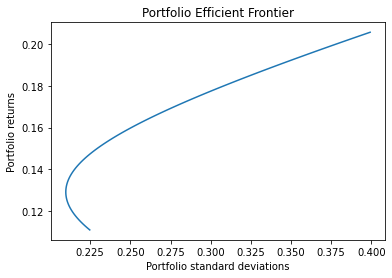

In [12]:
PlotEF(returns, corr,1/5)

## 3.2. The point to the far left 

The point to the far left is called the Global Minimum Variance Portfolio (GMVP). As the name indicates, this is the portfolio for which the variance is minimal on the efficient frontier.

## 3.3. EF with correlation = -1 

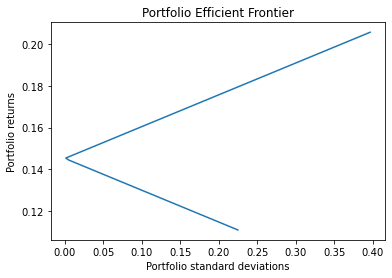

In [13]:
PlotEF(returns, -1, 1/5)

If the two securities are perfectly negatively correlated (corr = -1) then we can effectively remove any risk in the form of portfolio volatility while maintaining a positive return. This is an arbitrage opportunity as we ensure positive return with zero risk.

## 3.4. EF with correlation = 0 

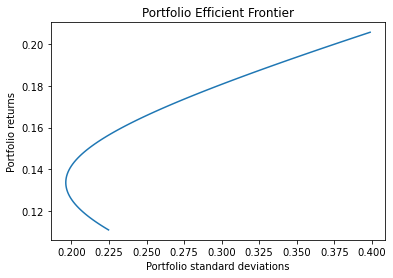

In [14]:
PlotEF(returns, 0,1/5)

For corr = 0, the securities have no correlation. Compared to the 0.18 correlation computed above, this correlation allow us to get the same portfolio return for a reduced risk as measured by the portfolio volatility.

## 3.5. EF with correlation = 1 

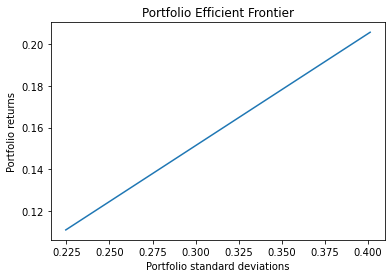

In [15]:
PlotEF(returns, 1,1/5)

For perfectly correlated securities (corr = 1), we essentially are investing in the same securities but scaled differently. We have a linear relationship between these two securities, which explains the straight line observed above.

## 3.6. Apply 5% trim to the data.  Recompute the correlation.  Rerun the EF.   

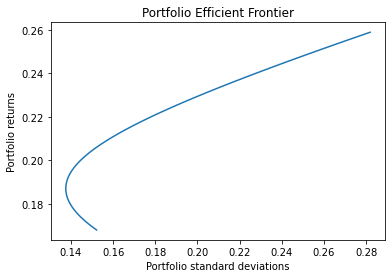

In [16]:
quantiles = returns.quantile([0.025, 0.975])
returns_trimmed = returns.apply(lambda x: x[(x>quantiles.loc[0.025,x.name]) & 
                                    (x < quantiles.loc[0.975,x.name])]).dropna()

corr = returns_trimmed.corr(method='pearson', min_periods=1).iloc[0,1]

PlotEF(returns_trimmed, corr, 1/5)

In [17]:
an_port_return_trim = portreturn_2(returns_trimmed,[0.5,0.5],1/5)*100
print("annualised return (in %): ", an_port_return_trim)
an_port_std_trim = portstd_2(returns_trimmed,[0.5,0.5])*100
print("annualised std of returns (in %): ", an_port_std_trim)

annualised return (in %):  21.392341464253317
annualised std of returns (in %):  16.55161024147963


When we trim the 5% most extreme returns, we effectvely remove some of the volatility (ie. risk) from our portfolio. This is shown by the graph above where the overall minimum portfolio volatility at the GMVP is much lower. Moreover the annualised std of returns is lower than for the non-trimmed portfolio (16.55% vs 24.77%). We also increase the annualised return from the portfolio (21.73% vs 15.88%).

## 3.8	Use a robust method of portfolio (see FRAPO R Library or pyportfolioopt Python module, for example).  
 

In [18]:
#!pip install PyPortfolioOpt

In [19]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from matplotlib.ticker import FuncFormatter

In [20]:
def FigPortFolioopt(returns_df, min_vol):

    mu = expected_returns.mean_historical_return(returns_df,returns_data=True)
    S = risk_models.sample_cov(returns_df,returns_data=True)

    results_opt = pd.DataFrame(columns = ["weights","returns","std","sharpe"])

    for vol in np.linspace(min_vol, 0.6, 1000):
        ef = EfficientFrontier(mu, S,  weight_bounds=(0, 1))
        ef.efficient_risk(vol)
        results_opt.loc[vol,"weights"] = ef.clean_weights().values()
        results_opt.loc[vol,"returns"], results_opt.loc[vol,"std"], results_opt.loc[vol,"sharpe"] = ef.portfolio_performance()
    
    plt.plot(results_opt["std"], results_opt["returns"])
    plt.xlabel("Portfolio standard deviations")
    plt.ylabel("Portfolio returns")
    plt.title('Portfolio Efficient Frontier')
    plt.show()
    return (results_opt)

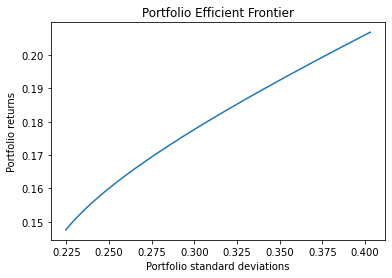

,weights,returns,std,sharpe
0.224709,"(0.37936, 0.62064)",0.147567,0.224709,0.567697
0.225085,"(0.38181, 0.61819)",0.147802,0.225085,0.567792
0.225461,"(0.38424, 0.61576)",0.148034,0.225461,0.567875
0.225836,"(0.38665, 0.61335)",0.148263,0.225836,0.567947
0.226212,"(0.38902, 0.61098)",0.14849,0.226212,0.568008
...,...,...,...,...
0.598497,"(1.0, 0.0)",0.206858,0.402909,0.463772
0.598873,"(1.0, 0.0)",0.206858,0.402909,0.463772
0.599249,"(1.0, 0.0)",0.206858,0.402909,0.463772
0.599624,"(1.0, 0.0)",0.206858,0.402909,0.463772


In [21]:
res_2S = FigPortFolioopt(returns, min(returns.std()*np.sqrt(252)))
res_2S

In [22]:
res_2S = res_2S.astype({"returns": 'float',"std": 'float',"sharpe": 'float'})
res_2S[res_2S['std'].round(3) == 0.248 ]

,weights,returns,std,sharpe
0.247625,"(0.49959, 0.50041)",0.159053,0.247625,0.561545
0.248001,"(0.50125, 0.49875)",0.159211,0.248001,0.561335
0.248376,"(0.50291, 0.49709)",0.159370,0.248376,0.561123


## 3.9	State the equation(s) of how this works.  Write a paragraph explaining how it works.  

The robust method of portfolio refers to the concept of mean variance optimization. This is a mathematical application of a convex optimization problem in  finance by exploring different combination of return and risk on the curve in order to get an optimal point that fulfills a given objective. A convex problem has the following form:

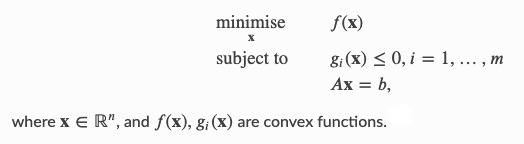

In [23]:
from IPython.display import Image 
pil_img = Image(filename='equ.png')
display(pil_img) 

This works similar to any optimization problem by defining a specific object, such as in this case maximizing a portfolio’s return and given a constrain such as a certain level of risk. This could also go the other way around by assigning the object as minimizing the level of volatility or risk with respect to a certain level of return. This process can be implemented using the  PyPortfolioOpt on python. The main advantage is that the implementation can be carried out easily and the package allows to add additional objectives.  

## 3.10.	How does this EF compare with the other 2 

Here, for the same level of risk (volatility = 24.77%) we find that the optimised portfolio offers a slightly better return using weights that are slightly tweaked but close to 0.5. Using the efficient frontier plotted we can adjust the portfolio depending on preferences in terms of risk/reward.

# 4	Category 2 Portfolio: 3 Sectors
## 4.1	Add 1 ETF to your portfolio.  Calculate the correlation matrix for 3 ETFs chosen.  

 

In [24]:
portfolio3S = df[['GDX','XLB', 'XLU']]
portfolio.head()

Symbols,GDX,XLB
Date,,
2016-01-04,14.09,42.740002
2016-01-05,14.02,42.720001
2016-01-06,14.25,41.599998
2016-01-07,14.88,40.470001
2016-01-08,14.52,40.060001


In [25]:
returns3S = portfolio3S.pct_change().dropna()
corr3S = returns3S.corr()
corr3S

Symbols,GDX,XLB,XLU
Symbols,,,
GDX,1.000000,0.180187,0.196241
XLB,0.180187,1.000000,0.554393
XLU,0.196241,0.554393,1.000000


## 4.2	Graph the efficient frontier of this 3-security portfolio.
 

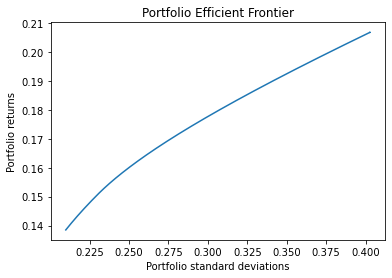

,weights,returns,std,sharpe
0.209933,"(0.33297, 0.52959, 0.13744)",0.13849,0.209933,0.564416
0.210324,"(0.3347, 0.53086, 0.13444)",0.138757,0.210324,0.564639
0.210714,"(0.33642, 0.53214, 0.13144)",0.139023,0.210714,0.564853
0.211105,"(0.33814, 0.53338, 0.12848)",0.139287,0.211105,0.565059
0.211495,"(0.33984, 0.53463, 0.12553)",0.139549,0.211495,0.565256
...,...,...,...,...
0.598438,"(1.0, 0.0, 0.0)",0.206858,0.402909,0.463772
0.598829,"(1.0, 0.0, 0.0)",0.206858,0.402909,0.463772
0.599219,"(1.0, 0.0, 0.0)",0.206858,0.402909,0.463772
0.599610,"(1.0, 0.0, 0.0)",0.206858,0.402909,0.463772


In [26]:
res_3S = FigPortFolioopt(returns3S,min(returns3S.std()*np.sqrt(252)))
res_3S

In [27]:
res_3S = res_3S.astype({"returns": 'float',"std": 'float',"sharpe": 'float'})
res_3S[(res_3S['std'].round(3) == 0.247) | (res_3S['std'].round(3) == 0.248)]

,weights,returns,std,sharpe
0.246636,"(0.49518, 0.50482, 0.0)",0.158632,0.246636,0.562089
0.247027,"(0.49693, 0.50307, 0.0)",0.158798,0.247027,0.561876
0.247417,"(0.49866, 0.50134, 0.0)",0.158964,0.247417,0.561660
0.247808,"(0.5004, 0.4996, 0.0)",0.159130,0.247808,0.561443
0.248198,"(0.50212, 0.49788, 0.0)",0.159295,0.248198,0.561223


## 4.3	Is there a diversification benefit to adding Security #3?  Explain your answer.


It seems that there is little difference between the 3 sector and the two sector portfolios. The overall return for the optmised portfolio is similar to before. When we look at the correlation matrix of the selected SPDRs computed above, we see that they are highly correlated. This could explain why diversifying does not make much difference.  

# 5	Category 3 Portfolios:  All Combinations


In [28]:
train = df[(df.index <="2019-12-31") & (df.index>="2019-01-01")].pct_change().dropna()
test = df[(df.index >"2019-12-31")].pct_change().dropna()

### 5.2	Assume a fixed amount of risk.  Use each portfolio's EF to determine the weights of each of the 3 securities.


In [29]:
import itertools
import copy

results = pd.DataFrame(columns = ["securities",'weights','returns',"volatilities","sharpe_ratios"])
risk_level = an_port_std/100
ind = 0

for subset in itertools.combinations(train, 3):
    ind += 1
    port_returns = train[list(subset)]
    mu = expected_returns.mean_historical_return(port_returns, returns_data = True)
    S = risk_models.sample_cov(port_returns, returns_data = True) 
    ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
    ef.efficient_risk(risk_level)
    results.loc[ind,"securities"] = list(subset)
    results.loc[ind,"weights"] = ef.clean_weights().values()
    results.loc[ind,"returns"], results.loc[ind,"volatilities"], results.loc[ind,"sharpe_ratios"] = ef.portfolio_performance()

results

,securities,weights,returns,volatilities,sharpe_ratios
1,"[XLE, XLF, XLU]","(-1.0, 1.0, 1.0)",0.499444,0.194266,2.46797
2,"[XLE, XLF, XLI]","(-1.0, 1.0, 1.0)",0.515487,0.210658,2.35209
3,"[XLE, XLF, GDX]","(-0.83483, 1.0, 0.83483)",0.588262,0.247718,2.29398
4,"[XLE, XLF, XLK]","(-1.0, 1.0, 1.0)",0.73629,0.231848,3.08948
5,"[XLE, XLF, XLV]","(-1.0, 1.0, 1.0)",0.452306,0.197126,2.19304
...,...,...,...,...,...
161,"[XLV, XLB, XOP]","(0.73554, 1.0, -0.73554)",0.452021,0.247718,1.744
162,"[XLY, XLP, XLB]","(1.0, 1.0, -1.0)",0.296639,0.156653,1.76593
163,"[XLY, XLP, XOP]","(1.0, 0.71666, -0.71666)",0.53124,0.247718,2.0638
164,"[XLY, XLB, XOP]","(1.0, 0.75688, -0.75688)",0.517587,0.247718,2.00868


### 5.3	Rank the 2019 portfolio returns.


In [30]:
results = results.sort_values('returns', ascending = False)
results = results.reset_index().drop("index", axis =1)
results

,securities,weights,returns,volatilities,sharpe_ratios
0,"[GDX, XLK, XOP]","(0.55374, 1.0, -0.55374)",0.770999,0.247718,3.03167
1,"[XLF, XLK, XOP]","(0.69815, 1.0, -0.69815)",0.769924,0.247718,3.02733
2,"[XLE, GDX, XLK]","(-0.74147, 0.74147, 1.0)",0.751767,0.247718,2.95403
3,"[XLI, XLK, XOP]","(0.69148, 1.0, -0.69148)",0.751163,0.247718,2.95159
4,"[XLE, XLF, XLK]","(-1.0, 1.0, 1.0)",0.73629,0.231848,3.08948
...,...,...,...,...,...
160,"[XLI, XLY, XLP]","(1.0, 1.0, -1.0)",0.269213,0.237382,1.04984
161,"[XLU, XLI, XLP]","(-1.0, 1.0, 1.0)",0.264766,0.220894,1.10807
162,"[XLU, XLY, XLP]","(-1.0, 1.0, 1.0)",0.263559,0.207708,1.1726
163,"[XLV, XLP, XLB]","(-1.0, 1.0, 1.0)",0.26278,0.178164,1.36268


### 5.4	Test each of the 165 portfolios using 2020 daily return data.  


In [31]:
results_2020 = pd.DataFrame(columns = ["securities",'weights','returns',"volatilities"])

for index, row in results.iterrows():
    ret_2020 = test[row["securities"]]
    weights = list(row["weights"])
    results_2020.loc[index,"securities"] = row["securities"]
    results_2020.loc[index,"weights"] = weights
    results_2020.loc[index,"returns"] = portreturn_2(ret_2020,weights,1)
    results_2020.loc[index,"volatilities"] = portstd_2(ret_2020,weights)

results_2020 = results_2020.sort_values("returns",ascending = False).reset_index().drop("index", axis = 1)
results_2020

,securities,weights,returns,volatilities
0,"[XLE, XLK, XLY]","[-1.0, 1.0, 1.0]",1.03349,0.535026
1,"[XLE, XLK, XLB]","[-1.0, 1.0, 1.0]",0.959194,0.49258
2,"[XLE, XLK, XLV]","[-1.0, 1.0, 1.0]",0.877348,0.536916
3,"[XLE, XLK, XLP]","[-1.0, 1.0, 1.0]",0.846153,0.533602
4,"[XLE, GDX, XLK]","[-0.74147, 0.74147, 1.0]",0.838323,0.583759
...,...,...,...,...
160,"[XLF, XLP, XLB]","[1.0, 1.0, -1.0]",-0.164521,0.373393
161,"[XLF, XLI, XLB]","[1.0, 1.0, -1.0]",-0.177328,0.495996
162,"[XLF, XLU, XLV]","[1.0, 1.0, -1.0]",-0.179617,0.553226
163,"[XLF, XLI, XLY]","[1.0, 1.0, -1.0]",-0.251623,0.562704


### 5.5	Rank the 2020 portfolio returns.


In [32]:
results_2020

,securities,weights,returns,volatilities
0,"[XLE, XLK, XLY]","[-1.0, 1.0, 1.0]",1.03349,0.535026
1,"[XLE, XLK, XLB]","[-1.0, 1.0, 1.0]",0.959194,0.49258
2,"[XLE, XLK, XLV]","[-1.0, 1.0, 1.0]",0.877348,0.536916
3,"[XLE, XLK, XLP]","[-1.0, 1.0, 1.0]",0.846153,0.533602
4,"[XLE, GDX, XLK]","[-0.74147, 0.74147, 1.0]",0.838323,0.583759
...,...,...,...,...
160,"[XLF, XLP, XLB]","[1.0, 1.0, -1.0]",-0.164521,0.373393
161,"[XLF, XLI, XLB]","[1.0, 1.0, -1.0]",-0.177328,0.495996
162,"[XLF, XLU, XLV]","[1.0, 1.0, -1.0]",-0.179617,0.553226
163,"[XLF, XLI, XLY]","[1.0, 1.0, -1.0]",-0.251623,0.562704


# 6	Analyzing 3-Security Portfolio


### 6.1	Relabel the ETF with a + sign if the weight >0, or a - sign if the weight <0.  Then add the assigned Economic Indicator.


In [33]:
results_sub2 = pd.read_csv('results_summary_S2.csv')
results_sub2.head()

,Unnamed: 0,level_0,Symbols,coefs,score,mse
0,4,LEI,GDX,[-2.79184640e-03 -6.71582729e+00 -4.72323768e+...,0.888943,1.551320
1,11,LEI,SPY,[ 4.18833921e-03 1.44728231e+01 1.84790354e+...,0.508760,144.113454
2,7,LEI,XLY,[ 7.37944434e-03 -1.17953142e+00 -2.84459695e+...,0.469848,24.516201
3,5,LEI,XLK,[ 4.39197325e-03 6.94193857e+00 -9.21022956e+...,0.307864,41.641353
4,2,LEI,XLU,[-5.63878016e-03 1.72283911e-01 2.41290497e+...,0.225806,13.140333


In [34]:
def assign_indicator(df):
    results_with_ind = df.copy()
    results_with_ind["indicators"] = None
    for index, row in results_with_ind.iterrows():
        lst_ind = []
        for i in range(len(row["securities"])):
            security = row["securities"][i]
            if row["weights"][i] < 0:
                lst_ind.append("-" + list(results_sub2.loc[results_sub2["Symbols"] == security,"level_0"])[0])
            else: lst_ind.append(list(results_sub2.loc[results_sub2["Symbols"] == security,"level_0"])[0])
        results_with_ind.iloc[index,4] = list(lst_ind)
    return results_with_ind
result_ind = assign_indicator(results_2020)
result_ind.head()


,securities,weights,returns,volatilities,indicators
0,"[XLE, XLK, XLY]","[-1.0, 1.0, 1.0]",1.03349,0.535026,"[-LEI, LEI, LEI]"
1,"[XLE, XLK, XLB]","[-1.0, 1.0, 1.0]",0.959194,0.49258,"[-LEI, LEI, ALL]"
2,"[XLE, XLK, XLV]","[-1.0, 1.0, 1.0]",0.877348,0.536916,"[-LEI, LEI, CEI]"
3,"[XLE, XLK, XLP]","[-1.0, 1.0, 1.0]",0.846153,0.533602,"[-LEI, LEI, LEI]"
4,"[XLE, GDX, XLK]","[-0.74147, 0.74147, 1.0]",0.838323,0.583759,"[-LEI, LEI, LEI]"


### 6.2	Using the ranks from 5.5, determine which combinations tend to be the best performing.  Interpret the results.


In [35]:
result_ind[["indicators","returns","volatilities"]].astype({"returns":'float64','volatilities':'float64'}).groupby(result_ind["indicators"].map(tuple))[["returns","volatilities"]].mean().sort_values("returns", ascending = False)

,returns,volatilities
indicators,,
"(-LEI, LEI, ALL)",0.679148,0.458121
"(-LEI, CEI, ALL)",0.677709,0.424620
"(-LEI, CEI, LEI)",0.658336,0.473368
"(-LEI, LEI, CEI)",0.572871,0.483343
"(CEI, ALL, -LEI)",0.554920,0.481238
"(-LEI, LEI, LEI)",0.537039,0.493123
"(CEI, LEI, -LEI)",0.520030,0.489686
"(LEI, ALL, -LEI)",0.501782,0.493417
"(LEI, CEI, -LEI)",0.393472,0.493449


The best returns are given on average by a combination of funds explained by either Leading indicators or all indicators. As stated in the previous submission, funds explained mostly by Leading Indicators are funds that track the main sources of input and output in the economy. These funds are linked to value adding companies and they are the main source of economic growth and therefore of investment return. This explains why the highest returns are found in these funds. It should be noted however that the volatilities are relatively high for these portfolios. 

# 7	Category 4 Portfolios: Using Principal Components

## 7.1 Compute the PCA from the correlation matrix of the 11 ETFs.

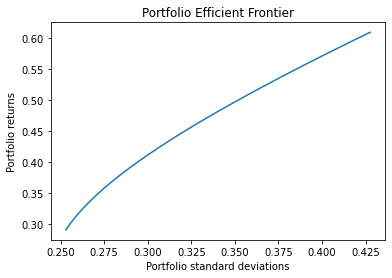

,weights,returns,std,sharpe
0.252985,"(0.37161, 0.00636, 0.62203)",0.290844,0.252985,1.07059
0.253333,"(0.37281, 0.00474, 0.62245)",0.292238,0.253333,1.07463
0.253680,"(0.37402, 0.00312, 0.62286)",0.29363,0.25368,1.07864
0.254027,"(0.37522, 0.00151, 0.62327)",0.29502,0.254027,1.08264
0.254375,"(0.37652, 0.0, 0.62348)",0.296407,0.254375,1.08661
...,...,...,...,...
0.598611,"(1.0, 0.0, 0.0)",0.609369,0.42767,1.37809
0.598958,"(1.0, 0.0, 0.0)",0.609369,0.42767,1.37809
0.599305,"(1.0, 0.0, 0.0)",0.609369,0.42767,1.37809
0.599653,"(1.0, 0.0, 0.0)",0.609369,0.42767,1.37809


In [36]:
from sklearn.decomposition import PCA
# standardize returns
returns_z = (train-train.mean())/train.std()
#PCA
pca = PCA(n_components = 3)
pca.fit(returns_z)

#Get transformed returns from components
trans_return = pd.DataFrame(pca.transform(train), index = train.index)

FigPortFolioopt(trans_return,min(trans_return.std()*np.sqrt(252)))

We consider the transformed returns to be the new portfolio returns and we assign a weight to each portfolio in proportion of it's contribution to the total variance.

In [37]:
#Define weights
weights_pca = pca.explained_variance_/sum(pca.explained_variance_)
#Compute the overall return of the portfolio 
return_pca = portreturn_2(trans_return,weights_pca,1)
std_pca = portstd_2(trans_return,weights_pca)
print(return_pca*100, std_pca*100)

35.56733263068702 33.10935380451504


## 7.2 How does the PCA portfolio return compare to the 2019  3-security portfolio returns?


The return of the portfolio is lower than these of the best 3-security portfolio. However the volatility is lower and this portfolio could be a better choice for a more risk averse investor.

## 7.3 Assuming a fixed amount of risk, and 2020 data, use the PC weights to compute the 3-PC portfolio returns.


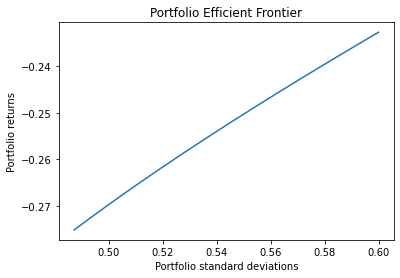

,weights,returns,std,sharpe
0.487171,"(0.0, 0.32992, 0.67008)",-0.275181,0.487171,-0.605909
0.487284,"(0.0, 0.3297, 0.6703)",-0.275132,0.487284,-0.605668
0.487396,"(0.0, 0.32947, 0.67053)",-0.275083,0.487397,-0.605427
0.487509,"(0.0, 0.32925, 0.67075)",-0.275034,0.487509,-0.605186
0.487622,"(0.0, 0.32902, 0.67098)",-0.274985,0.487622,-0.604945
...,...,...,...,...
0.599548,"(0.0, 0.13619, 0.86381)",-0.232822,0.599548,-0.421688
0.599661,"(0.0, 0.13602, 0.86398)",-0.232784,0.599661,-0.421545
0.599774,"(0.0, 0.13584, 0.86416)",-0.232746,0.599774,-0.421401
0.599887,"(0.0, 0.13567, 0.86433)",-0.232707,0.599887,-0.421258


In [38]:
trans_returns_2020 = pd.DataFrame(pca.transform(test), index = test.index)
FigPortFolioopt(trans_returns_2020,min(trans_returns_2020.std()*np.sqrt(252)))

In [39]:
#Compute the overall return of the portfolio 
return_pca_2020 = portreturn_2(trans_returns_2020,weights_pca,1)
std_pca_2020 = portstd_2(trans_returns_2020,weights_pca)
print(return_pca_2020*100, std_pca_2020*100)

-33.447689828296404 85.7684992985759


For 2020, the PCA porfolio performs much worse than the previous 3-security portfolio. By choosing the combination of ETF that explain most of the variance we do not differentiate between positive and negative variance. As negative returns are usually more extreme than positive one, it is not unlikely that choosing the most variance diminishes the overall return as we also get more extreme negative returns.The recent crisis linked to the coronavirus could have put pressure on funds that had a strong volatility of returns in 2019.